# Group Project: Minh Trinh - Hazel Choe (Financial Analysis section)
## Name: Minh Trinh 👨🏻‍🎓

### 1. Library 📚📚📚

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [2]:
tickers = ['BLK', 'JPM', 'WHG', 'FHI', 'AMG', 'DHIL', 'AB', 'KO', 'NSRGY', 'WMK', 'WDFC','TR', 'JJSF', 'FDP']

# Download data from yfinance
data = yf.download(tickers, start="2004-01-01", end="2024-12-31", group_by='ticker', auto_adjust=True)
adj_close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
df = adj_close.pct_change().dropna()
df = df.reset_index()

df


[*********************100%***********************]  14 of 14 completed


,Date,BLK,JPM,WHG,FHI,AMG,DHIL,AB,KO,NSRGY,WMK,WDFC,TR,JJSF,FDP
0,2004-01-05,0.052972,-0.001912,0.000000,0.042332,0.035837,0.066177,0.027536,0.001191,0.030303,-0.002181,0.032612,0.001102,0.020526,-0.002100
1,2004-01-06,0.007036,0.025171,-0.005624,0.008655,0.008719,0.000000,0.012694,-0.004165,0.003096,-0.015574,-0.021352,0.015956,0.003353,0.002105
2,2004-01-07,0.013100,0.014679,-0.007919,0.007921,0.011524,0.041380,0.005572,-0.006374,-0.006173,0.007217,-0.010629,-0.001896,0.002313,-0.015546
3,2004-01-08,-0.000518,0.017096,0.003421,0.027832,0.010444,-0.059603,0.008310,0.004811,0.016304,0.006613,-0.001979,-0.003255,-0.007692,0.012377
4,2004-01-09,-0.006382,0.002328,-0.033523,-0.004460,0.000000,0.056338,-0.004121,-0.010575,0.000764,-0.033671,-0.103966,-0.020142,-0.005168,-0.013490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278,2024-12-23,0.010703,0.003325,-0.013725,-0.003167,0.011560,0.006727,-0.020666,-0.002718,-0.000486,-0.017511,-0.020045,-0.001572,-0.018860,0.001801
5279,2024-12-24,0.014552,0.016444,-0.022531,0.008798,0.015436,0.014157,0.008495,0.007374,0.000608,0.008985,0.011799,0.016688,0.002864,-0.000899
5280,2024-12-26,-0.000521,0.003425,-0.031186,0.005572,0.010560,0.016699,0.016576,-0.004297,0.001579,0.010073,-0.000968,0.012697,0.001841,0.011394
5281,2024-12-27,-0.009580,-0.008102,-0.013296,-0.002168,-0.009659,-0.006095,-0.004544,-0.001918,0.000000,-0.015609,-0.012521,-0.008563,-0.010516,-0.019271


### 2. Estimate normal returns (market model or CAPM).


In [3]:
market_index = '^GSPC'  # S&P 500
start_date = '2004-01-04'
end_date = '2022-12-30'

# Download market prices
sp500_data = yf.download(market_index, start=start_date, end=end_date, auto_adjust=True)
market_returns = sp500_data['Close'].pct_change().dropna()
stock_returns = adj_close.pct_change().dropna()

# Estimate normal returns using market model
results = {}
for ticker in tickers:
    df = pd.concat([stock_returns[ticker], market_returns], axis=1).dropna()
    df.columns = ['Stock', 'Market']
    X = sm.add_constant(df['Market'])
    y = df['Stock']

    model = sm.OLS(y, X).fit()
    results[ticker] = {
        'Alpha': model.params['const'],
        'Beta': model.params['Market'],
        'R-squared': model.rsquared
    }

results_df = pd.DataFrame(results).T
print(results_df)


[*********************100%***********************]  1 of 1 completed

          Alpha      Beta  R-squared
BLK    0.000408  1.322567   0.570272
JPM    0.000176  1.406767   0.548072
WHG    0.000065  1.053647   0.254084
FHI    0.000074  1.199405   0.447911
AMG    0.000065  1.548518   0.555228
DHIL   0.000878  0.962314   0.235177
AB     0.000136  1.285313   0.433366
KO     0.000183  0.594843   0.387308
NSRGY  0.000333  0.488000   0.245236
WMK    0.000239  0.644784   0.202167
WDFC   0.000320  0.776528   0.254412
TR     0.000077  0.637036   0.250391
JJSF   0.000378  0.813747   0.287541
FDP    0.000077  0.780270   0.176480


### 3. Define event window. Calculate abnormal returns (AR) and cumulative abnormal returns (CAR).

In [4]:
# Define window (10 days prior the event, 60 days after the event)
event_date = pd.to_datetime('2008-09-15')
start_window = event_date - pd.Timedelta(days=10)
end_window = event_date + pd.Timedelta(days=60)



In [5]:
ar_dict = {}
car_dict = {}

for ticker in tickers:
    df = pd.concat([stock_returns[ticker], market_returns], axis=1).dropna()
    df.columns = ['Stock', 'Market']
    
    # Regression parameters from Market Model
    alpha = results[ticker]['Alpha']
    beta = results[ticker]['Beta']
    
    # Normal return
    df['Normal'] = alpha + beta * df['Market']
    
    # Abnormal return
    df['AR'] = df['Stock'] - df['Normal']
    
    # Select event window
    df_event = df[(df.index >= start_window) & (df.index <= end_window)]
    
    # Store
    ar_dict[ticker] = df_event['AR']
    car_dict[ticker] = df_event['AR'].cumsum()


In [6]:
AR_df = pd.DataFrame(ar_dict)
CAR_df = pd.DataFrame(car_dict)

print("Abnormal Returns (AR) around 2008 event:")
print(AR_df.head())

print("\nCumulative Abnormal Returns (CAR) around 2008 event:")
print(CAR_df.head())


Abnormal Returns (AR) around 2008 event:
                 BLK       JPM       WHG       FHI       AMG      DHIL  \
Date                                                                     
2008-09-05 -0.003235  0.038170 -0.009249 -0.002250  0.006655 -0.009425   
2008-09-08  0.029993  0.020213  0.012339  0.011610  0.009551  0.026939   
2008-09-09 -0.013009 -0.002211 -0.038876 -0.000481 -0.011123  0.021922   
2008-09-10  0.018023 -0.010601  0.047260 -0.012173  0.012845  0.000738   
2008-09-11  0.001665  0.037508 -0.000120  0.008358 -0.019186  0.004475   

                  AB        KO     NSRGY       WMK      WDFC        TR  \
Date                                                                     
2008-09-05 -0.014134  0.001436  0.007982 -0.023293 -0.000264 -0.003975   
2008-09-08  0.026266  0.015538 -0.010342  0.015558  0.038357  0.010898   
2008-09-09 -0.019879  0.029490  0.031303  0.019137  0.008563  0.020619   
2008-09-10 -0.061763 -0.005140 -0.022630 -0.004468  0.020136  0.010035

In [7]:
rf_data = yf.download("^IRX", start=start_date, end=end_date, auto_adjust=True)['Close']

# Convert T-bill annualized % to daily decimal
rf_daily = (rf_data / 100) / 252
rf_daily.name = 'rf'


[*********************100%***********************]  1 of 1 completed


In [8]:
ar_dict = {}
car_dict = {}

for ticker in tickers:
    # Merge stock, market, and risk-free
    df = pd.concat([stock_returns[ticker], market_returns, rf_daily], axis=1).dropna()
    df.columns = ['Stock', 'Market', 'RF']
    
    # Excess returns
    df['Excess_Stock'] = df['Stock'] - df['RF']
    df['Excess_Market'] = df['Market'] - df['RF']
    
    # CAPM normal return
    alpha = results_df.loc[ticker, 'Alpha']
    beta = results_df.loc[ticker, 'Beta']
    df['Normal'] = alpha + beta * df['Excess_Market']
    
    # Abnormal return
    df['AR'] = df['Excess_Stock'] - df['Normal']
    
    # Event window
    df_event = df[(df.index >= start_window) & (df.index <= end_window)]
    
    # Store AR and CAR
    ar_dict[ticker] = df_event['AR']
    car_dict[ticker] = df_event['AR'].cumsum()


In [9]:
AR_df = pd.DataFrame(ar_dict)
CAR_df = pd.DataFrame(car_dict)


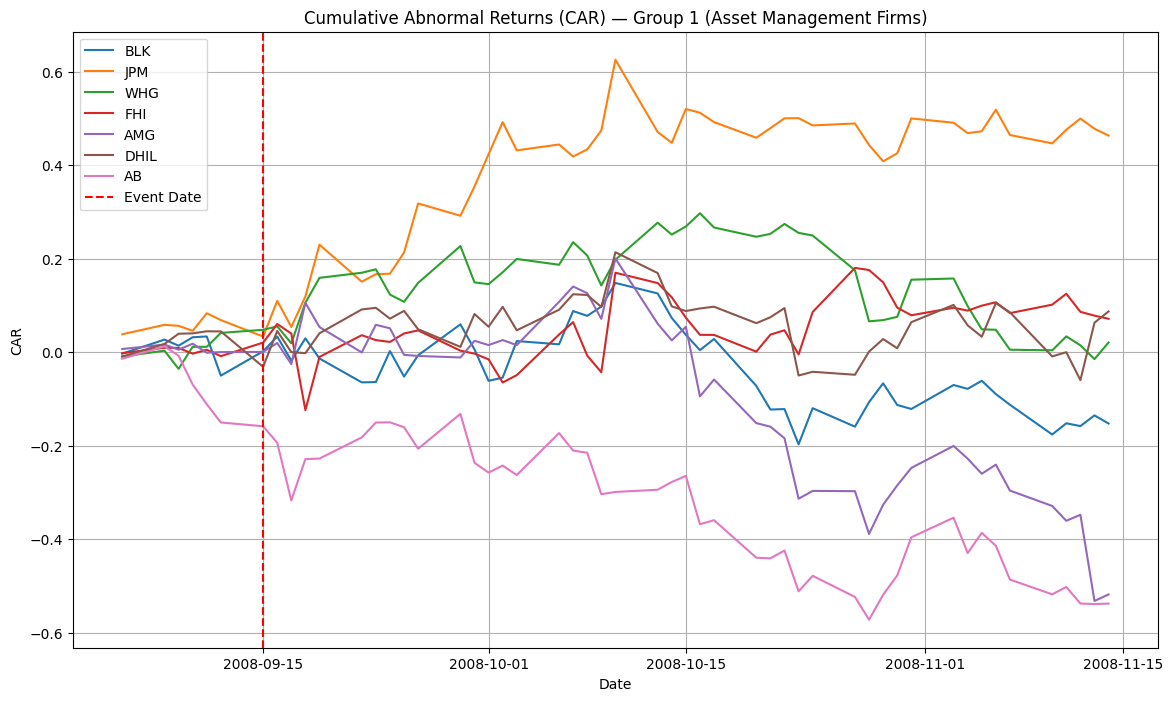

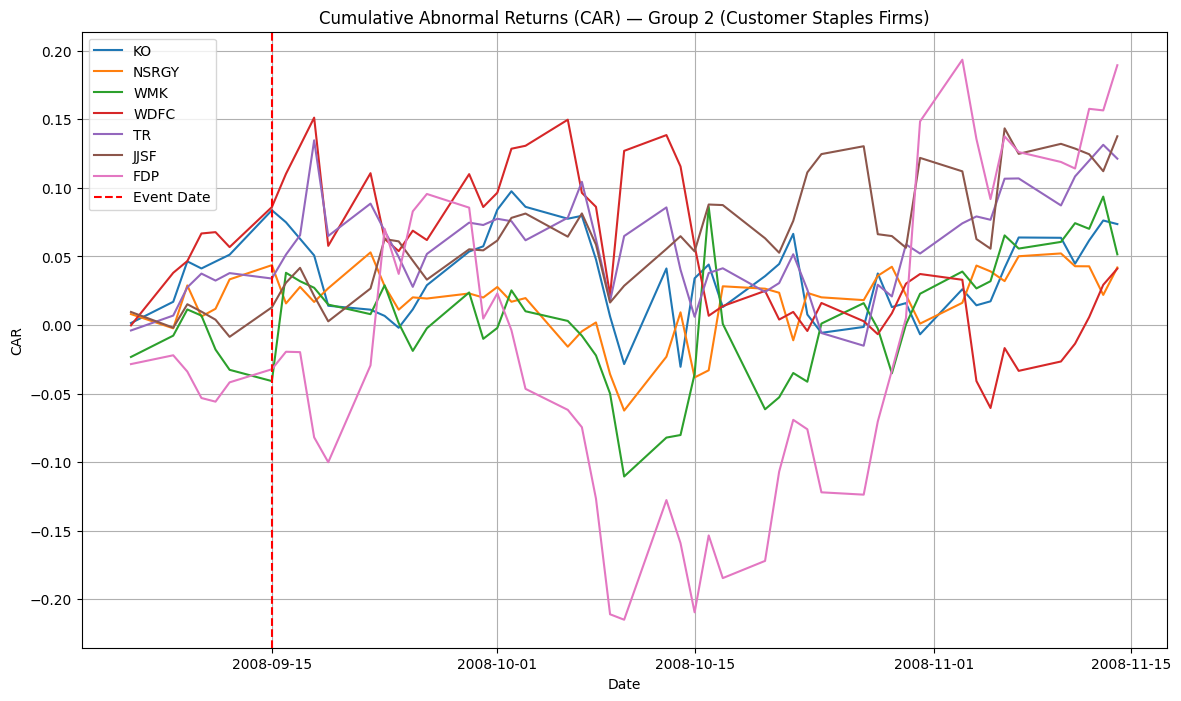

In [10]:
import matplotlib.pyplot as plt

# Split in two different plots (one for financial, one for non-financial)
tickers_group1 = ['BLK', 'JPM', 'WHG', 'FHI', 'AMG', 'DHIL', 'AB']
tickers_group2 = ['KO', 'NSRGY', 'WMK', 'WDFC', 'TR', 'JJSF', 'FDP']

# Plot for financial firms
plt.figure(figsize=(14,8))
for ticker in tickers_group1:
    plt.plot(CAR_df.index, CAR_df[ticker], label=ticker)

plt.axvline(event_date, color='red', linestyle='--', label='Event Date')
plt.title('Cumulative Abnormal Returns (CAR) — Group 1 (Asset Management Firms)')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.legend()
plt.grid(True)
plt.show()

# Plot for non-financial firms
plt.figure(figsize=(14,8))
for ticker in tickers_group2:
    plt.plot(CAR_df.index, CAR_df[ticker], label=ticker)

plt.axvline(event_date, color='red', linestyle='--', label='Event Date')
plt.title('Cumulative Abnormal Returns (CAR) — Group 2 (Customer Staples Firms)')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.legend()
plt.grid(True)
plt.show()

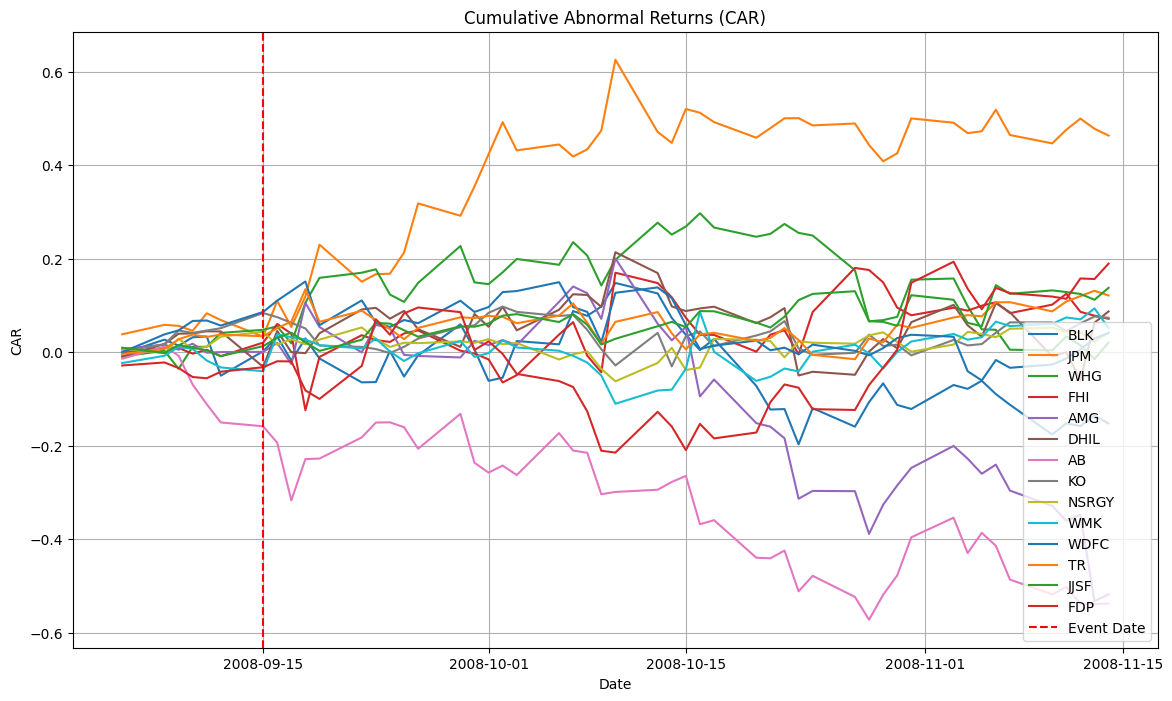

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
for ticker in tickers:
    plt.plot(CAR_df.index, CAR_df[ticker], label=ticker)

plt.axvline(event_date, color='red', linestyle='--', label='Event Date')
plt.title('Cumulative Abnormal Returns (CAR)')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.legend()
plt.grid(True)
plt.show()


## FAMA FRENCH 5 Factor Model

In [12]:
fama = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
fama

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15476,20241224,1.11,-0.12,-0.05,-0.13,-0.37,0.017
15477,20241226,0.02,1.09,-0.19,-0.44,0.35,0.017
15478,20241227,-1.17,-0.44,0.56,0.41,0.03,0.017
15479,20241230,-1.09,0.24,0.74,0.55,0.14,0.017


In [13]:
fama.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)


In [14]:
fama['Date'] = fama['Date'].astype(str)
fama['Date'] = pd.to_datetime(fama['Date'], format='%Y%m%d')

# Convert factors and RF to decimals
for col in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']:
    fama[col] = fama[col] / 100

# Check
print(fama['Date'].head())


0   1963-07-01
1   1963-07-02
2   1963-07-03
3   1963-07-05
4   1963-07-08
Name: Date, dtype: datetime64[ns]


### FAMA-FRENCH - COVID-19

In [15]:
data = yf.download(tickers, start="2020-01-01", end="2020-12-31", group_by='ticker', auto_adjust=True)

# Create a DataFrame with all tickers' adjusted close
price_data = pd.DataFrame({t: data[t]['Close'] for t in tickers})
price_data = price_data.reset_index()

# Calculate daily returns 
returns_df = price_data.copy()
for t in tickers:
    returns_df[t] = price_data[t].pct_change()
returns_df = returns_df.dropna()  
returns_df['Date'] = pd.to_datetime(returns_df['Date'])

# Merge returns with Fama-French data by Date
data_merged = pd.merge(returns_df, fama, on='Date', how='inner')

# Fama-French 5-Factor regression model
results = {}
for ticker in tickers:
    y = data_merged[ticker] - data_merged['RF']  # excess returns
    X = data_merged[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    results[ticker] = {
        "alpha": model.params["const"],
        "beta_MKT": model.params["Mkt-RF"],
        "beta_SMB": model.params["SMB"],
        "beta_HML": model.params["HML"],
        "beta_RMW": model.params["RMW"],
        "beta_CMA": model.params["CMA"],
        "rsquared": model.rsquared
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.index.name = "Ticker"
results_df = results_df.round(4)
print(results_df)





[*********************100%***********************]  14 of 14 completed


         alpha  beta_MKT  beta_SMB  beta_HML  beta_RMW  beta_CMA  rsquared
Ticker                                                                    
BLK     0.0010    1.1697   -0.1585    0.2347   -0.6706    0.0939    0.7269
JPM     0.0009    1.0290   -0.4442    1.4204   -0.6158   -0.5060    0.8999
WHG    -0.0019    1.0711    1.5305    0.7792   -0.1384   -1.4537    0.4880
FHI     0.0005    1.3078    0.1468    0.9283   -0.9411    0.4351    0.6726
AMG     0.0016    1.1673   -0.1570    0.7693   -0.1437    1.0138    0.7367
DHIL    0.0003    0.7175    0.7489    0.3453   -0.2533   -0.0098    0.5858
AB      0.0003    1.1918    0.9036    0.4193   -0.3939   -0.7973    0.6063
KO      0.0002    0.7571   -0.1944    0.2760   -0.0034    0.6900    0.6919
NSRGY  -0.0001    0.5594   -0.1480   -0.1144   -0.3753    0.2603    0.5553
WMK     0.0004    0.4855    0.2794   -0.2939   -0.0643    0.9108    0.1973
WDFC    0.0006    0.6133    0.5111   -0.5076    0.3542    0.8141    0.2390
TR     -0.0005    0.3672 

### FAMA-FRENCH model - 2008 Financial Crisis

In [16]:
data = yf.download(tickers, start="2008-01-01", end="2008-12-31", group_by='ticker', auto_adjust=True)

# Create a DataFrame with all tickers' adjusted close
price_data = pd.DataFrame({t: data[t]['Close'] for t in tickers})
price_data = price_data.reset_index() 

# Calculate daily returns 
returns_df = price_data.copy()
for t in tickers:
    returns_df[t] = price_data[t].pct_change()
returns_df = returns_df.dropna() 
returns_df['Date'] = pd.to_datetime(returns_df['Date'])

# Merge returns with Fama-French data by Date
data_merged = pd.merge(returns_df, fama, on='Date', how='inner')

# Fama-French 5-Factor regression model
results = {}
for ticker in tickers:
    y = data_merged[ticker] - data_merged['RF']  # excess returns
    X = data_merged[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    results[ticker] = {
        "alpha": model.params["const"],
        "beta_MKT": model.params["Mkt-RF"],
        "beta_SMB": model.params["SMB"],
        "beta_HML": model.params["HML"],
        "beta_RMW": model.params["RMW"],
        "beta_CMA": model.params["CMA"],
        "rsquared": model.rsquared
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.index.name = "Ticker"
results_df = results_df.round(4)
print(results_df)




[*********************100%***********************]  14 of 14 completed


         alpha  beta_MKT  beta_SMB  beta_HML  beta_RMW  beta_CMA  rsquared
Ticker                                                                    
BLK     0.0017    1.4546    0.7844   -0.0728   -0.7421    1.1884    0.6272
JPM     0.0010    1.0218    0.3306    2.2677    0.2622   -0.5120    0.7969
WHG     0.0017    1.1118    1.0922   -0.1751   -0.5314    0.0139    0.4794
FHI    -0.0013    1.0960    0.2754    0.7975    0.6442    0.2126    0.5156
AMG    -0.0000    1.2312    1.1894    0.9740   -0.8718   -1.7003    0.6968
DHIL    0.0025    1.0003    1.0596    0.3931    0.0315   -0.6810    0.4322
AB     -0.0017    1.3046    0.7824    0.6013   -0.6920    0.5224    0.6384
KO      0.0002    0.7285   -0.0912   -0.3074   -0.1133    1.1982    0.5213
NSRGY   0.0005    0.5078   -0.4606   -0.0422    0.0291    0.0486    0.4077
WMK     0.0002    0.7647    0.5650    0.1406    0.4903    0.6922    0.4914
WDFC   -0.0003    0.8995    1.0370    0.2857    0.8491    1.3499    0.5116
TR      0.0014    0.8447 

### 3. Run simulation

In [17]:
prices = yf.download(
    tickers,
    start="2007-01-01",
    end="2021-01-01",
    auto_adjust=True
)['Close']

returns = prices.pct_change().dropna()
returns.index = pd.to_datetime(returns.index)


[*********************100%***********************]  14 of 14 completed


In [18]:
fama['Date'] = pd.to_datetime(fama['Date'], format='%Y%m%d')
fama.set_index('Date', inplace=True)

# Convert percent → decimal
factors = ['Mkt-RF','SMB','HML','RMW','CMA','RF']
fama[factors] = fama[factors] / 100

In [19]:
data = returns.join(fama, how='inner').dropna()
data.head(10)
covid_data = data.loc['2020-01-04':'2020-12-31']
crisis2008_data = data.loc['2008-01-04':'2009-12-31']


#### CAPM Expected Return Estimation

In [20]:
def capm_expected_returns(data, tickers):
    mu = {}
    for t in tickers:
        y = data[t] - data['RF']
        X = sm.add_constant(data['Mkt-RF'])
        model = sm.OLS(y, X).fit()
        mu[t] = model.params['Mkt-RF'] * data['Mkt-RF'].mean()
    return pd.Series(mu)


#### Fama–French Five-Factor Expected Return Estimation

In [21]:
def ff_expected_returns(data, tickers):
    factors = ['Mkt-RF','SMB','HML','RMW','CMA']
    mu = {}
    for t in tickers:
        y = data[t] - data['RF']
        X = sm.add_constant(data[factors])
        model = sm.OLS(y, X).fit()
        mu[t] = model.params[factors] @ data[factors].mean()
    return pd.Series(mu)


In [22]:
def mean_variance_weights(mu, cov):
    inv_cov = np.linalg.pinv(cov)
    w = inv_cov @ mu
    return w / w.sum()


#### Portfolio Optimization

In [23]:
def run_simulation(data, tickers):
    cov_matrix = data[tickers].cov()
    capm_mu = capm_expected_returns(data, tickers)
    ff_mu   = ff_expected_returns(data, tickers)

    w_capm = mean_variance_weights(capm_mu, cov_matrix)
    w_ff   = mean_variance_weights(ff_mu, cov_matrix)

    return w_capm, w_ff


#### Crisis-Period Portfolio Weight Estimation

In [24]:
w_capm_covid, w_ff_covid = run_simulation(covid_data, tickers)
w_capm_2008, w_ff_2008   = run_simulation(crisis2008_data, tickers)

In [25]:
def portfolio_returns(returns_df, weights):
    return pd.Series(returns_df[tickers].values @ weights, index=returns_df.index)

covid_capm_r = portfolio_returns(covid_data, w_capm_covid)
covid_ff_r   = portfolio_returns(covid_data, w_ff_covid)
crisis_capm_r = portfolio_returns(crisis2008_data, w_capm_2008)
crisis_ff_r   = portfolio_returns(crisis2008_data, w_ff_2008)

In [26]:
covid_capm_cum = (1 + covid_capm_r).cumprod()
covid_ff_cum   = (1 + covid_ff_r).cumprod()
crisis_capm_cum = (1 + crisis_capm_r).cumprod()
crisis_ff_cum   = (1 + crisis_ff_r).cumprod()


#### Optimized Portfolio Weights Output

In [27]:
print("CAPM Weights COVID-19:\n", w_capm_covid)
print("Fama-French Weights COVID-19:\n", w_ff_covid)
print("CAPM Weights 2008 Crisis:\n", w_capm_2008)
print("Fama-French Weights 2008 Crisis:\n", w_ff_2008)

CAPM Weights COVID-19:
 [ 0.21123988  0.1602646   0.02650381 -0.05325156  0.0253292  -0.00740191
  0.06155314  0.15034783  0.28096731  0.02442723  0.05909168  0.01914701
  0.0436342  -0.0018524 ]
Fama-French Weights COVID-19:
 [ 0.77583959 -1.0364981   0.18460388 -0.38001165 -0.17981949  0.22114398
  0.32513641  0.11967568  0.37161062  0.14533377  0.22584948  0.05799032
  0.14826928  0.02087622]
CAPM Weights 2008 Crisis:
 [0.08018641 0.06463293 0.03042942 0.05989303 0.0553138  0.03137611
 0.05400988 0.17890351 0.18183527 0.0686806  0.03123287 0.04550474
 0.0990619  0.01893951]
Fama-French Weights 2008 Crisis:
 [ -6.55980614   4.62795914   0.58656685   0.49076738  -4.56931492
   0.85738651  -3.14692396 -14.36221728  -5.88224794   9.34150254
  11.58509691   5.91486825   0.56109415   1.55526853]


In [28]:
def portfolio_returns(returns_df, weights):
    return pd.Series(
        returns_df.values @ weights,
        index=returns_df.index
    )

In [29]:
def cumulative_returns(portfolio_r):
    return (1 + portfolio_r).cumprod()

In [30]:
def performance_metrics(portfolio_r):
    if isinstance(portfolio_r, np.ndarray):
        portfolio_r = pd.Series(portfolio_r)
        
    mean_ret = np.mean(portfolio_r) * 252  # annualized return
    vol = np.std(portfolio_r) * np.sqrt(252)  # annualized volatility
    sharpe = mean_ret / vol
    cum_r = cumulative_returns(portfolio_r)
    drawdown = (cum_r / cum_r.cummax() - 1).min()
    return {'Annualized Return': mean_ret, 'Volatility': vol, 'Sharpe Ratio': sharpe, 'Max Drawdown': drawdown}



In [31]:
covid_returns = covid_data[tickers]
crisis2008_returns = crisis2008_data[tickers]

# Compute portfolio returns
covid_capm_r = portfolio_returns(covid_returns, w_capm_covid)
covid_ff_r   = portfolio_returns(covid_returns, w_ff_covid)

crisis_capm_r = portfolio_returns(crisis2008_returns, w_capm_2008)
crisis_ff_r   = portfolio_returns(crisis2008_returns, w_ff_2008)

# Compute cumulative returns
covid_capm_cum = cumulative_returns(covid_capm_r)
covid_ff_cum   = cumulative_returns(covid_ff_r)

crisis_capm_cum = cumulative_returns(crisis_capm_r)
crisis_ff_cum   = cumulative_returns(crisis_ff_r)

# Compute performance metrics
covid_capm_perf = performance_metrics(covid_capm_r)
covid_ff_perf   = performance_metrics(covid_ff_r)

crisis_capm_perf = performance_metrics(crisis_capm_r)
crisis_ff_perf   = performance_metrics(crisis_ff_r)

#### Portfolio Performance Output

In [32]:
print("COVID-19 CAPM Portfolio Performance:\n", covid_capm_perf)
print("COVID-19 Fama-French Portfolio Performance:\n", covid_ff_perf)
print("2008 Crisis CAPM Portfolio Performance:\n", crisis_capm_perf)
print("2008 Crisis Fama-French Portfolio Performance:\n", crisis_ff_perf)


COVID-19 CAPM Portfolio Performance:
 {'Annualized Return': np.float64(0.22003179609228382), 'Volatility': np.float64(0.3233064012405553), 'Sharpe Ratio': np.float64(0.6805673975151816), 'Max Drawdown': np.float64(-0.29248271753105937)}
COVID-19 Fama-French Portfolio Performance:
 {'Annualized Return': np.float64(0.48304260857597264), 'Volatility': np.float64(0.47047493524778344), 'Sharpe Ratio': np.float64(1.0267127372504345), 'Max Drawdown': np.float64(-0.2319671198123071)}
2008 Crisis CAPM Portfolio Performance:
 {'Annualized Return': np.float64(0.12046227401844917), 'Volatility': np.float64(0.3491198307088038), 'Sharpe Ratio': np.float64(0.34504563597513066), 'Max Drawdown': np.float64(-0.40071750304940346)}
2008 Crisis Fama-French Portfolio Performance:
 {'Annualized Return': np.float64(1.8670330257387238), 'Volatility': np.float64(7.8277289638012775), 'Sharpe Ratio': np.float64(0.2385152876872299), 'Max Drawdown': np.float64(-5.61064043415923)}


#### Data Visualization

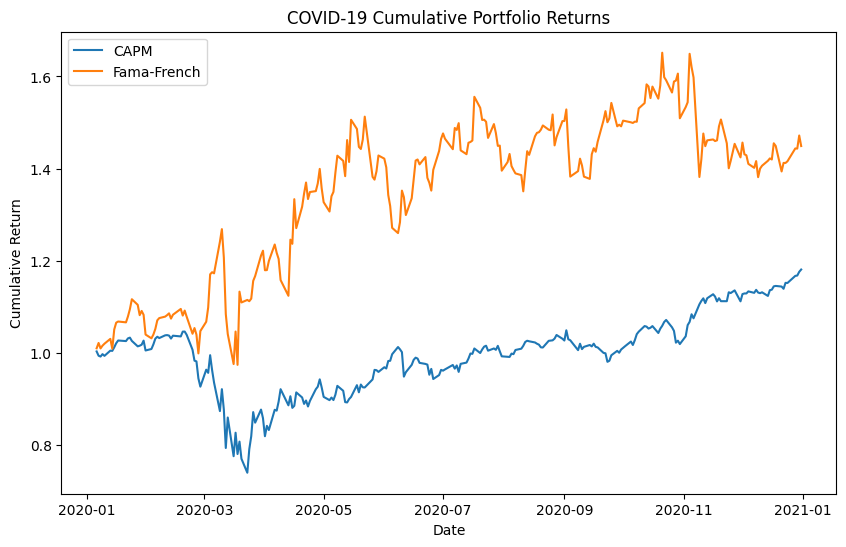

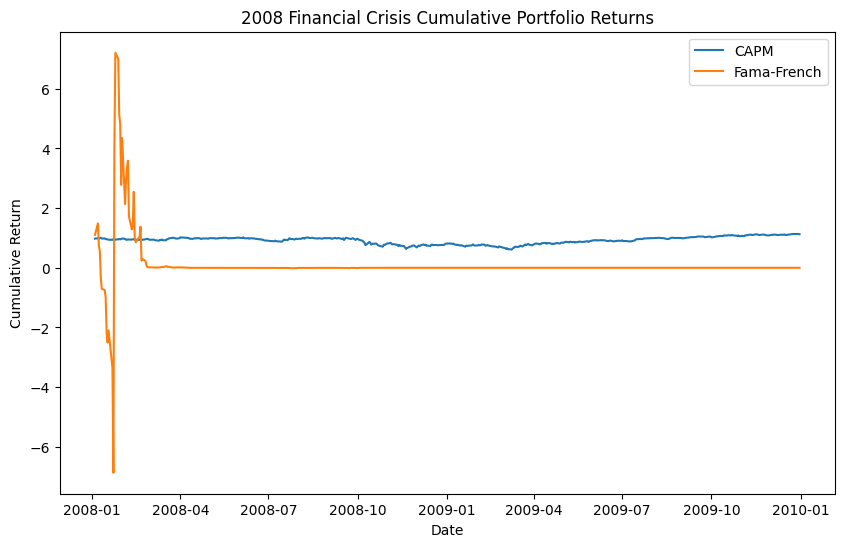

In [33]:
# COVID-19
plt.figure(figsize=(10,6))
plt.plot(covid_capm_cum, label='CAPM')
plt.plot(covid_ff_cum, label='Fama-French')
plt.title('COVID-19 Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# 2008 Crisis
plt.figure(figsize=(10,6))
plt.plot(crisis_capm_cum, label='CAPM')
plt.plot(crisis_ff_cum, label='Fama-French')
plt.title('2008 Financial Crisis Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [34]:
crisis_data = {
    'COVID': {
        'CAPM': {k:v for k,v in covid_capm_perf.items() if k in ['Annualized Return','Volatility']},
        'FF':   {k:v for k,v in covid_ff_perf.items() if k in ['Annualized Return','Volatility']}
    },
    '2008': {
        'CAPM': {k:v for k,v in crisis_capm_perf.items() if k in ['Annualized Return','Volatility']},
        'FF':   {k:v for k,v in crisis_ff_perf.items() if k in ['Annualized Return','Volatility']}
    }
}

days_per_year = 252
simulations = 1000 

#### Monte Carlo Portfolio Return Simulation

In [35]:
def simulate_portfolio(annual_return, annual_vol, days=252, sims=1000):
    daily_return = annual_return / days
    daily_vol = annual_vol / np.sqrt(days)
    
    results = []
    for _ in range(sims):
        daily_returns = np.random.normal(daily_return, daily_vol, days)
        cum_returns = np.cumprod(1 + daily_returns)
        results.append(cum_returns)
    return np.array(results)

#### Monte Carlo Portfolio Optimization

In [36]:
def optimize_portfolio(mean_returns, cov_matrix, sims=5000):
    num_assets = len(mean_returns)
    best_sharpe = -np.inf
    best_weights = None
    
    for _ in range(sims):
        weights = np.random.rand(num_assets)
        weights /= np.sum(weights)
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = port_return / port_vol
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_weights = weights
    return best_weights, best_sharpe


In [37]:
covid_capm = simulate_portfolio(crisis_data['COVID']['CAPM']['Annualized Return'],
                                crisis_data['COVID']['CAPM']['Volatility'],
                                days_per_year, simulations)

covid_ff = simulate_portfolio(crisis_data['COVID']['FF']['Annualized Return'],
                              crisis_data['COVID']['FF']['Volatility'],
                              days_per_year, simulations)


In [38]:
mean_returns = np.array([crisis_data['COVID']['CAPM']['Annualized Return'],
                         crisis_data['COVID']['FF']['Annualized Return']])
cov_matrix = np.cov(np.array([covid_capm.mean(axis=1), covid_ff.mean(axis=1)]))

opt_weights, opt_sharpe = optimize_portfolio(mean_returns, cov_matrix)

#### Combining both CAPM and Fama-French portfolio returns using optimized weights

In [39]:
optimized_portfolio = opt_weights[0] * covid_capm + opt_weights[1] * covid_ff
optimized_mean_cum_return = optimized_portfolio.mean(axis=0)


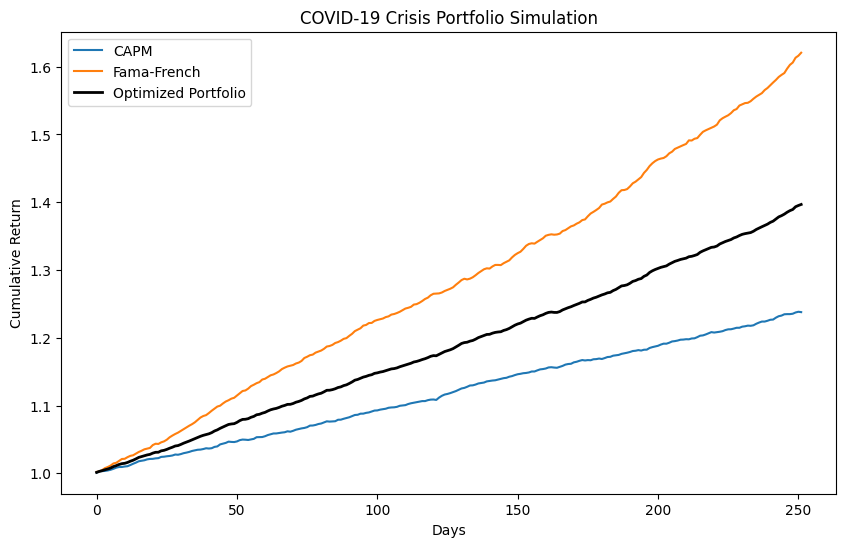

In [40]:
plt.figure(figsize=(10,6))
plt.plot(covid_capm.mean(axis=0), label='CAPM')
plt.plot(covid_ff.mean(axis=0), label='Fama-French')
plt.plot(optimized_mean_cum_return, label='Optimized Portfolio', linewidth=2, color='black')
plt.title("COVID-19 Crisis Portfolio Simulation")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [41]:
financial_capm = simulate_portfolio(crisis_data['2008']['CAPM']['Annualized Return'],
                                crisis_data['2008']['CAPM']['Volatility'],
                                days_per_year, simulations)

financial_ff = simulate_portfolio(crisis_data['2008']['FF']['Annualized Return'],
                              crisis_data['2008']['FF']['Volatility'],
                              days_per_year, simulations)

In [42]:
mean_returns = np.array([crisis_data['2008']['CAPM']['Annualized Return'],
                         crisis_data['2008']['FF']['Annualized Return']])
cov_matrix = np.cov(np.array([financial_capm.mean(axis=1), financial_ff.mean(axis=1)]))

opt_weights, opt_sharpe = optimize_portfolio(mean_returns, cov_matrix)

In [43]:
optimized_portfolio = opt_weights[0] * financial_capm + opt_weights[1] * covid_ff
optimized_mean_cum_return = optimized_portfolio.mean(axis=0)

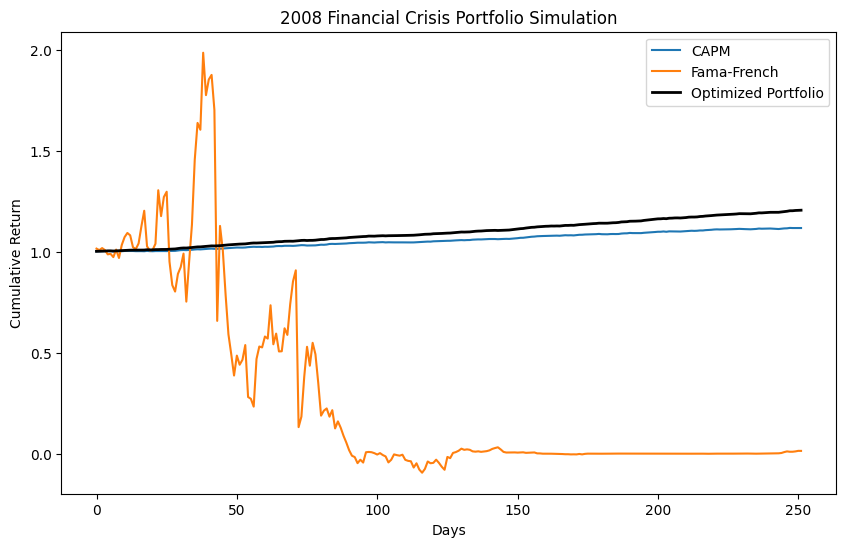

In [44]:
plt.figure(figsize=(10,6))
plt.plot(financial_capm.mean(axis=0), label='CAPM')
plt.plot(financial_ff.mean(axis=0), label='Fama-French')
plt.plot(optimized_mean_cum_return, label='Optimized Portfolio', linewidth=2, color='black')
plt.title("2008 Financial Crisis Portfolio Simulation")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()